In [1]:
import requests
import time
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

In [2]:
from sqlalchemy import create_engine, inspect

In [3]:
import pickle as pkl

In [4]:
from datetime import timedelta

In [5]:
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from sklearn.metrics import roc_curve, auc

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn import pipeline, preprocessing

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
from sklearn.metrics import precision_recall_curve

In [15]:
from sklearn.metrics import average_precision_score

In [16]:
from sklearn.metrics import recall_score

In [17]:
df=pd.read_csv('./data/start-up_mod.csv',index_col=0 )

In [18]:
df.columns

Index(['status', 'category_code', 'CA', 'NY', 'MA', 'TX', 'WA',
       'founded_month', 'first_funding_dayinop', 'ave_inf_y',
       'ag_funded_daysop', 'ag_raised_amount_usd_adj', 'cr_funded_daysop',
       'cr_raised_amount_usd_adj'],
      dtype='object')

In [19]:
y1,X1=dmatrices('''status ~ category_code  + CA + NY + MA + TX + WA + founded_month 
                + first_funding_dayinop + ave_inf_y 
                + ag_funded_daysop + ag_raised_amount_usd_adj
                + cr_funded_daysop + cr_raised_amount_usd_adj''',data=df,return_type='dataframe')

In [20]:
X1=X1.drop(columns='Intercept')


In [21]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3812 entries, 0 to 3851
Data columns (total 51 columns):
category_code[T.analytics]           3812 non-null float64
category_code[T.automotive]          3812 non-null float64
category_code[T.biotech]             3812 non-null float64
category_code[T.cleantech]           3812 non-null float64
category_code[T.consulting]          3812 non-null float64
category_code[T.design]              3812 non-null float64
category_code[T.ecommerce]           3812 non-null float64
category_code[T.education]           3812 non-null float64
category_code[T.enterprise]          3812 non-null float64
category_code[T.fashion]             3812 non-null float64
category_code[T.finance]             3812 non-null float64
category_code[T.games_video]         3812 non-null float64
category_code[T.hardware]            3812 non-null float64
category_code[T.health]              3812 non-null float64
category_code[T.hospitality]         3812 non-null float64
category

In [22]:
y1['status[acquired]'].sum()/len(y1)

0.1820566631689402

In [23]:
y1_ac=y1['status[acquired]']

In [24]:
##logistc regression and auc estimates

X1_train,X1_test, y1_ac_train, y1_ac_test = train_test_split(X1,y1_ac,test_size=0.2, random_state=42)

tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2'] }

log_ac = GridSearchCV(LogisticRegression(), tuned_parameters, scoring='roc_auc', cv=3, refit=True)
    
log_ac.fit(X1_train,y1_ac_train)
y_score=log_ac.predict_proba(X1_test)[:,1]

fpr1_ac, tpr1_ac,_ = roc_curve(y1_ac_test, y_score)
roc_auc1_ac = auc(fpr1_ac, tpr1_ac)

y_score1=log_ac.predict_proba(X1_train)[:,1]

fpr1_ac_train, tpr1_ac_train,_ = roc_curve(y1_ac_train, y_score1)
roc_auc1_ac_train = auc(fpr1_ac_train, tpr1_ac_train)

print(roc_auc1_ac,roc_auc1_ac_train)

0.6391700404858299 0.7053313452959021


In [25]:
y1['status[ipo]'].sum()/len(y1)

0.025183630640083946

In [26]:
y1_ipo=y1['status[ipo]']

In [27]:
## logistic regression or ipo category
X1_train,X1_test, y1_ipo_train, y1_ipo_test = train_test_split(X1,y1_ipo,test_size=0.2, random_state=42)


tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2'] }

log_ipo = GridSearchCV(LogisticRegression(), tuned_parameters, scoring='roc_auc', cv=3, refit=True)

log_ipo.fit(X1_train,y1_ipo_train)
y_score=log_ipo.predict_proba(X1_test)[:,1]

fpr1_ipo, tpr1_ipo,_ = roc_curve(y1_ipo_test, y_score)
roc_auc1_ipo = auc(fpr1_ipo, tpr1_ipo)

y_score=log_ipo.predict_proba(X1_train)[:,1]

fpr1_ipo_train, tpr1_ipo_train,_ = roc_curve(y1_ipo_train, y_score)
roc_auc1_ipo_train = auc(fpr1_ipo_train, tpr1_ipo_train)

print(roc_auc1_ipo,roc_auc1_ipo_train)

0.6318856582014476 0.8051510333863275


In [28]:
## logistic regression with normallized variables and calculating AUC

# log_ac_p=pipeline.Pipeline([
#     ('standardscaler',preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)),
#     ( 'log', LogisticRegression())
# ])

norm=preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)

X1_train_n=norm.fit_transform(X1_train)

X1_test_n = norm.transform(X1_test)

tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2'] }


log_ac_n=GridSearchCV(LogisticRegression(), tuned_parameters, scoring='roc_auc', cv=3, refit=True)

log_ac_n.fit(X1_train_n,y1_ac_train)
y_score=log_ac_n.predict_proba(X1_test_n)[:,1]

fpr1_ac_n, tpr1_ac_n,_ = roc_curve(y1_ac_test, y_score)
roc_auc1_ac_n = auc(fpr1_ac, tpr1_ac)

y_score=log_ac_n.predict_proba(X1_train_n)[:,1]

fpr1_ac_n_train, tpr1_ac_n_train,_ = roc_curve(y1_ac_train, y_score)
roc_auc1_ac_n_train = auc(fpr1_ac_train, tpr1_ac_train)

print(roc_auc1_ac, roc_auc1_ac_n_train )

0.6391700404858299 0.7053313452959021


In [29]:
## logistic regression with normallized variables and calculating AUC

log_ipo_n=GridSearchCV(LogisticRegression(), tuned_parameters, scoring='roc_auc', cv=3, refit=True)

log_ipo_n.fit(X1_train_n,y1_ipo_train)
y_score=log_ipo_n.predict_proba(X1_test_n)[:,1]

fpr1_ipo_n, tpr1_ipo_n,_ = roc_curve(y1_ipo_test, y_score)
roc_auc1_ipo_n = auc(fpr1_ipo_n, tpr1_ipo_n)

y_score=log_ipo_n.predict_proba(X1_train_n)[:,1]

fpr1_ipo_n_train, tpr1_ipo_n_train,_ = roc_curve(y1_ipo_train, y_score)
roc_auc1_ipo_n_train = auc(fpr1_ipo_n_train, tpr1_ipo_n_train)

print(roc_auc1_ipo_n, roc_auc1_ipo_n_train)

0.6985032511348301 0.779404951169657


In [30]:
# random forest model for AC
tuned_parameters= { 
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,4,5],
    'criterion' :['gini', 'entropy']
}

randomforest_ac =  GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring='roc_auc', cv=3, refit=True)
randomforest_ac.fit(X1_train,y1_ac_train)
y_score=randomforest_ac.predict_proba(X1_test)[:,1]

fpr2_ac, tpr2_ac,_ = roc_curve(y1_ac_test, y_score)
roc_auc2_ac = auc(fpr2_ac, tpr2_ac)


y_score=randomforest_ac.predict_proba(X1_train)[:,1]

fpr2_ac_train, tpr2_ac_train,_ = roc_curve(y1_ac_train, y_score)
roc_auc2_ac_train = auc(fpr2_ac_train, tpr2_ac_train)


In [31]:
print(roc_auc2_ac, roc_auc2_ac_train)

0.6365212335257128 0.7736297775821794


In [32]:
# random forest model for IPO

tuned_parameters= { 
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,4,5],
    'criterion' :['gini', 'entropy']
}
randomforest_ipo = GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring='roc_auc', cv=3, refit=True)
randomforest_ipo.fit(X1_train,y1_ipo_train)

y_score=randomforest_ipo.predict_proba(X1_test)[:,1]
fpr2_ipo, tpr2_ipo,_ = roc_curve(y1_ipo_test, y_score)
roc_auc2_ipo = auc(fpr2_ipo, tpr2_ipo)

y_score_train=randomforest_ipo.predict_proba(X1_train)[:,1]
fpr2_ipo_train, tpr2_ipo_train,_ = roc_curve(y1_ipo_train, y_score_train)
roc_auc2_ipo_train = auc(fpr2_ipo_train, tpr2_ipo_train)
    

roc_auc2_ipo, roc_auc2_ipo_train 

(0.685621396147712, 0.9265137406313877)

In [33]:
# Gradient Boosting Classifier on ipo
learning_rates = np.logspace(-4, -0.5, 30)
max_features= range(1,5)
tuned_parameters = [{'learning_rate': learning_rates, 'max_features':max_features,'n_estimators':[300] }]
n_folds = 3


GBC_ipo=GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring='roc_auc', cv=n_folds, refit=True)


GBC_ipo.fit(X1_train,y1_ipo_train)

y_score=GBC_ipo.predict_proba(X1_test)[:,1]
fpr3_ipo, tpr3_ipo,_ = roc_curve(y1_ipo_test, y_score)
roc_auc3_ipo = auc(fpr3_ipo, tpr3_ipo)

y_score_train=GBC_ipo.predict_proba(X1_train)[:,1]
fpr3_ipo_train, tpr3_ipo_train,_ = roc_curve(y1_ipo_train, y_score_train)
roc_auc3_ipo_train = auc(fpr3_ipo_train, tpr3_ipo_train)

 

In [34]:
roc_auc3_ipo, roc_auc3_ipo_train 

(0.6642436510857564, 0.9428526004996594)

In [35]:
# Gradient Boosting Classifier on AC

learning_rates = np.logspace(-4, -0.5, 30)
max_features= range(1,5)
tuned_parameters = [{'learning_rate': learning_rates, 'max_features':max_features,'n_estimators':[300] }]
n_folds = 3


GBC_ac=GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring='roc_auc', cv=n_folds, refit=True)


GBC_ac.fit(X1_train,y1_ac_train)

y_score=GBC_ac.predict_proba(X1_test)[:,1]
fpr3_ac, tpr3_ac,_ = roc_curve(y1_ac_test, y_score)
roc_auc3_ac = auc(fpr3_ac, tpr3_ac)

y_score_train=GBC_ac.predict_proba(X1_train)[:,1]
fpr3_ac_train, tpr3_ac_train,_ = roc_curve(y1_ac_train, y_score_train)
roc_auc3_ac_train = auc(fpr3_ac_train, tpr3_ac_train)

roc_auc3_ac, roc_auc3_ac_train 

(0.6493399517615642, 0.8057843941024173)

In [36]:
#Support vector machine on IPO

tuned_parameters = [
  {'C': [1, 10, 50], 'kernel': ['linear'],'probability':[True]},
  {'C': [1, 10, 50], 'gamma': [0.001, 0.0001,0.01], 'kernel': ['rbf'],'probability':[True]},
 ]


SVC1_ipo=GridSearchCV(SVC(), tuned_parameters, scoring='roc_auc', cv=n_folds, refit=True)

SVC1_ipo.fit(X1_train_n,y1_ipo_train)

y_score=SVC1_ipo.predict_proba(X1_test_n)[:,1]
fpr4_ipo, tpr4_ipo,_ = roc_curve(y1_ipo_test, y_score)
roc_auc4_ipo = auc(fpr4_ipo, tpr4_ipo)

y_score=SVC1_ipo.predict_proba(X1_train_n)[:,1]
fpr4_ipo_train, tpr4_ipo_train,_ = roc_curve(y1_ipo_train, y_score)
roc_auc4_ipo_train = auc(fpr4_ipo_train, tpr4_ipo_train)

roc_auc4_ipo, roc_auc4_ipo_train

(0.5558827137774506, 0.627047467635703)

In [37]:
#Support vector machine on ac

tuned_parameters = [
  {'C': [1, 10, 50], 'kernel': ['linear'],'probability':[True]},
  {'C': [1, 10, 50], 'gamma': [0.001, 0.0001,0.01], 'kernel': ['rbf'],'probability':[True]},
 ]

SVC1_ac=GridSearchCV(SVC(), tuned_parameters, scoring='roc_auc', cv=n_folds, refit=True)

SVC1_ac.fit(X1_train_n,y1_ac_train)

y_score=SVC1_ac.predict_proba(X1_test_n)[:,1]
fpr4_ac, tpr4_ac,_ = roc_curve(y1_ac_test, y_score)
roc_auc4_ac = auc(fpr4_ac, tpr4_ac)

y_score=SVC1_ac.predict_proba(X1_train_n)[:,1]
fpr4_ac_train, tpr4_ac_train,_ = roc_curve(y1_ac_train, y_score)
roc_auc4_ac_train = auc(fpr4_ac_train, tpr4_ac_train)

roc_auc4_ac, roc_auc4_ac_train

(0.5954108881040572, 0.6398924340260554)

In [38]:
#Naive-Bayes on IPO, it does not have hyperparameters 
bayes_ipo = naive_bayes.GaussianNB() # The likelihood of the features is assumed to be Gaussian

bayes_ipo.fit(X1_train,y1_ipo_train)

y_score=bayes_ipo.predict_proba(X1_test)[:,1]
fpr6_ipo, tpr6_ipo,_ = roc_curve(y1_ipo_test, y_score)
roc_auc6_ipo = auc(fpr6_ipo, tpr6_ipo)

y_score=bayes_ipo.predict_proba(X1_train)[:,1]
fpr6_ipo_train, tpr6_ipo_train,_ = roc_curve(y1_ipo_train, y_score)
roc_auc6_ipo_train = auc(fpr6_ipo_train, tpr6_ipo_train)

roc_auc6_ipo, roc_auc6_ipo_train

(0.5933014354066986, 0.6251260504201681)

In [39]:
#Naive-Bayes on ac, it does not have hyperparameters 
bayes_ac = naive_bayes.GaussianNB() # The likelihood of the features is assumed to be Gaussian

bayes_ac.fit(X1_train,y1_ac_train)

y_score=bayes_ac.predict_proba(X1_test)[:,1]
fpr6_ac, tpr6_ac,_ = roc_curve(y1_ac_test, y_score)
roc_auc6_ac = auc(fpr6_ac, tpr6_ac)

y_score=bayes_ac.predict_proba(X1_train)[:,1]
fpr6_ac_train, tpr6_ac_train,_ = roc_curve(y1_ac_train, y_score)
roc_auc6_ac_train = auc(fpr6_ac_train, tpr6_ac_train)

In [40]:
def cv_Bayes(X1, y1_ipo):
    X1_train,X1_test, y1_ipo_train, y1_ipo_test = train_test_split(X1,y1_ipo,test_size=0.2)
    
    bayes = naive_bayes.GaussianNB() # The likelihood of the features is assumed to be Gaussian
   
    bayes.fit(X1_train,y1_ipo_train)

    y_score=bayes.predict_proba(X1_test)[:,1]
    fpr2_ipo, tpr2_ipo,_ = roc_curve(y1_ipo_test, y_score)
    roc_auc2_ipo = auc(fpr2_ipo, tpr2_ipo)

    y_score_train=bayes.predict_proba(X1_train)[:,1]
    fpr2_ipo_train, tpr2_ipo_train,_ = roc_curve(y1_ipo_train, y_score_train)
    roc_auc2_ipo_train = auc(fpr2_ipo_train, tpr2_ipo_train)

    
    return roc_auc2_ipo,roc_auc2_ipo_train,bayes,X1_train,X1_test, y1_ipo_train, y1_ipo_test

In [41]:
def Bayes_afew_times(X1, y1_ipo, n=10):
    info= (pd.DataFrame([cv_Bayes(X1, y1_ipo) for j in range(n)],
                         columns=['Test auc','Train auc', 'Model', 'X1_train','X1_test','y1_train', 'y1_test']))
    
#         (pd.DataFrame([mod_SVC(X1, y1_ipo) for j in range(n)],
#                          columns=['Test auc','Train auc'])).mean()
                         
                         
    return info

In [42]:
info_b_ipo=Bayes_afew_times(X1, y1_ipo,n=10)

In [43]:
np.mean(info_b_ipo['Train auc'])

0.6397516831755101

In [44]:
np.mean(info_b_ipo['Test auc'])

0.6301049594203698

In [45]:
info_b_ac=Bayes_afew_times(X1, y1_ac,n=10)

In [46]:
info_b_ac

,Test auc,Train auc,Model,X1_train,X1_test,y1_train,y1_test
0,0.608082,0.570564,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,510 0.0 2422 1.0 184 0.0 3275 0....,814 0.0 3035 0.0 182 0.0 2193 0....
1,0.612811,0.569027,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,3471 0.0 3787 1.0 711 1.0 1383 0....,2857 0.0 1945 0.0 1317 0.0 2505 0....
2,0.573011,0.583250,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,1356 0.0 19 1.0 2492 0.0 1888 0....,2861 0.0 1102 0.0 1980 0.0 1023 0....
3,0.563299,0.579428,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,2418 0.0 3118 0.0 3197 0.0 1620 0....,3453 0.0 2288 0.0 2858 0.0 3136 0....
4,0.608857,0.568661,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,1788 0.0 3666 0.0 3601 1.0 2591 0....,3572 0.0 3028 0.0 2246 0.0 3588 0....
5,0.566606,0.589064,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,3077 0.0 365 0.0 2433 0.0 685 0....,3583 0.0 1501 0.0 416 0.0 411 0....
6,0.597721,0.584892,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,1609 0.0 2247 0.0 128 0.0 860 0....,1940 0.0 1711 1.0 1394 0.0 2632 0....
7,0.582807,0.586972,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,1604 0.0 519 0.0 1647 0.0 802 0....,3557 0.0 2824 0.0 617 0.0 1245 0....
8,0.576526,0.576844,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,1607 0.0 920 0.0 1568 1.0 1694 1....,347 0.0 540 0.0 2745 0.0 2424 0....
9,0.527282,0.594523,GaussianNB(priors=None),category_code[T.analytics] category_cod...,category_code[T.analytics] category_cod...,3490 0.0 545 1.0 24 0.0 454 0....,356 1.0 1129 0.0 2988 0.0 2770 0....


In [47]:
np.mean(info_b_ac['Train auc'])

0.5803225107676317

In [48]:
np.mean(info_b_ac['Test auc'])

0.581700161115784

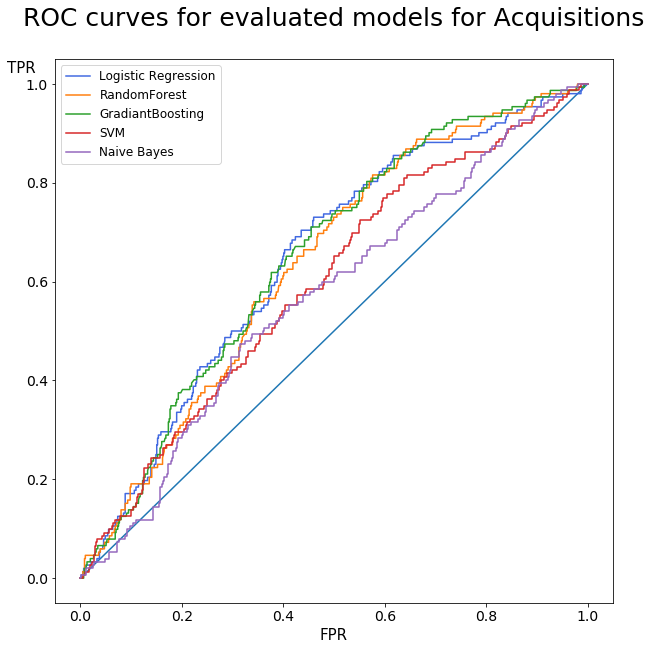

In [49]:

plt.figure(figsize= [10,10])
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr1_ac_n,tpr1_ac_n,label='Logistic Regression', color='royalblue')
#plt.plot(fpr1_ac,tpr1_ac,label='logr_ac')
plt.plot(fpr2_ac,tpr2_ac,label='RandomForest')
plt.plot(fpr3_ac,tpr3_ac,label='GradiantBoosting')
plt.plot(fpr4_ac,tpr4_ac,label='SVM')
plt.plot(fpr6_ac,tpr6_ac,label='Naive Bayes')
plt.xlabel('FPR', size = 15)
plt.ylabel('TPR', size = 15,rotation = 0,labelpad = 35)
plt.legend(loc='best',prop={'size': 12})
plt.title("ROC curves for evaluated models for Acquisitions", size = 25)
# plt.xlabel('Coefficients', size = 15, labelpad = 15)
# plt.ylabel('Variables        ', size = 20, rotation = 0, labelpad = 35)
plt.xticks(size=14)
plt.yticks(size=14)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.06,0.97)
ttl = ax.title
ttl.set_position([.5, 1.05]);


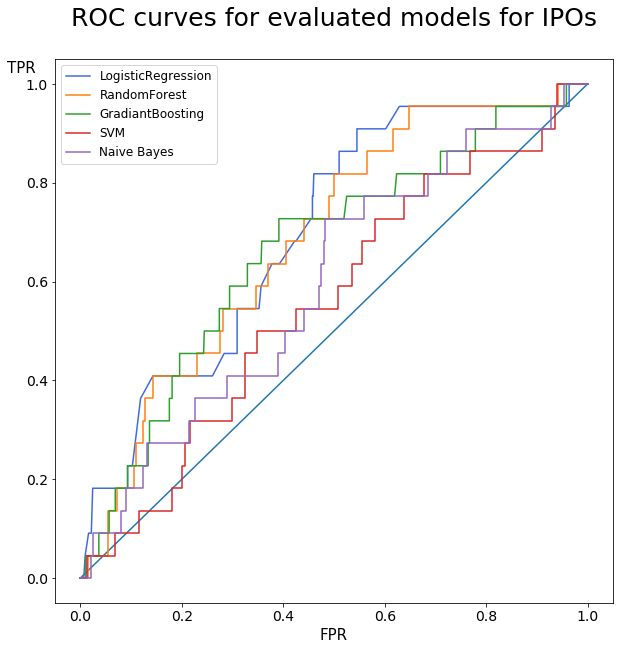

In [50]:

plt.figure(figsize= [10,10])
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr1_ipo_n,tpr1_ipo_n,label='LogisticRegression', color='royalblue')
# plt.plot(fpr1_ipo,tpr1_ipo,label='logr_ac')
plt.plot(fpr2_ipo,tpr2_ipo,label='RandomForest')
plt.plot(fpr3_ipo,tpr3_ipo,label='GradiantBoosting')
plt.plot(fpr4_ipo,tpr4_ipo,label='SVM')
plt.plot(fpr6_ipo,tpr6_ipo,label='Naive Bayes')
plt.xlabel('FPR', size = 15)
plt.ylabel('TPR', size = 15,rotation = 0,labelpad = 35)
plt.legend(loc='best',prop={'size': 12})
plt.title("ROC curves for evaluated models for IPOs", size = 25)
# plt.xlabel('Coefficients', size = 15, labelpad = 15)
# plt.ylabel('Variables        ', size = 20, rotation = 0, labelpad = 35)
plt.xticks(size=14)
plt.yticks(size=14)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.06,0.97)
ttl = ax.title
ttl.set_position([.5, 1.05]);

In [51]:
Name=['logr', 'logr_n','RandomForest', 'GradiantBoosting','SVM','N Bayes']

In [52]:
Model_ac=[log_ac,log_ac_n,randomforest_ac,GBC_ac,SVC1_ac,bayes_ac]

In [53]:
Model_ipo=[log_ipo,log_ipo_n,randomforest_ipo,GBC_ipo,SVC1_ipo,bayes_ipo]

In [54]:
auc_test_ac=[roc_auc1_ac,roc_auc1_ac_n, roc_auc2_ac,roc_auc3_ac,roc_auc4_ac, roc_auc6_ac]

In [55]:
auc_train_ac=[roc_auc1_ac_train, roc_auc1_ac_n_train, roc_auc2_ac_train,roc_auc3_ac_train,roc_auc4_ac_train, roc_auc6_ac_train]

In [56]:
auc_test_ipo=[roc_auc1_ipo,roc_auc1_ipo_n, roc_auc2_ipo,roc_auc3_ipo,roc_auc4_ipo, roc_auc6_ipo]

In [57]:
auc_train_ipo=[roc_auc1_ipo_train,roc_auc1_ipo_n_train, roc_auc2_ipo_train,roc_auc3_ipo_train,roc_auc4_ipo_train, roc_auc6_ipo_train]

In [58]:
fpr_ipo =[fpr1_ipo,fpr1_ipo_n,fpr2_ipo,fpr3_ipo,fpr4_ipo,fpr6_ipo]

In [59]:
fpr_ac =[fpr1_ac,fpr1_ac_n,fpr2_ac,fpr3_ac,fpr4_ac,fpr6_ac]

In [60]:
tpr_ac =[tpr1_ac,tpr1_ac_n,tpr2_ac,tpr3_ac,tpr4_ac,tpr6_ac]

In [61]:
tpr_ipo =[tpr1_ipo,tpr1_ipo_n,tpr2_ipo,tpr3_ipo,tpr4_ipo,tpr6_ipo]

In [62]:
fpr_ipo_train =[fpr1_ipo_train,fpr1_ipo_n_train,fpr2_ipo_train,fpr3_ipo_train,fpr4_ipo_train,fpr6_ipo_train]

In [63]:
fpr_ac_train =[fpr1_ac_train,fpr1_ac_n_train,fpr2_ac_train,fpr3_ac_train,fpr4_ac_train,fpr6_ac_train]

In [64]:
tpr_ipo_train =[tpr1_ipo_train,tpr1_ipo_n_train,tpr2_ipo_train,tpr3_ipo_train,tpr4_ipo_train,tpr6_ipo_train]

In [65]:
tpr_ac_train =[tpr1_ac_train,tpr1_ac_n_train,tpr2_ac_train,tpr3_ac_train,tpr4_ac_train,tpr6_ac_train]

In [66]:
Model_data_ac=pd.DataFrame({'name':Name, 'model':Model_ac,'auc_test_ac':auc_test_ac,
                            'auc_train_ac':auc_train_ac })

In [67]:
Model_data_ipo=pd.DataFrame({'name':Name, 'model':Model_ipo,'auc_test_ipo':auc_test_ipo,
                            'auc_train_ipo':auc_train_ipo})

In [68]:
Model_data_ac

,name,model,auc_test_ac,auc_train_ac
0,logr,"GridSearchCV(cv=3, error_score='raise',\n ...",0.639170,0.705331
1,logr_n,"GridSearchCV(cv=3, error_score='raise',\n ...",0.639170,0.705331
2,RandomForest,"GridSearchCV(cv=3, error_score='raise',\n ...",0.636521,0.773630
3,GradiantBoosting,"GridSearchCV(cv=3, error_score='raise',\n ...",0.649340,0.805784
4,SVM,"GridSearchCV(cv=3, error_score='raise',\n ...",0.595411,0.639892
5,N Bayes,GaussianNB(priors=None),0.568481,0.588555


In [69]:
Model_data_ipo

,name,model,auc_test_ipo,auc_train_ipo
0,logr,"GridSearchCV(cv=3, error_score='raise',\n ...",0.631886,0.805151
1,logr_n,"GridSearchCV(cv=3, error_score='raise',\n ...",0.698503,0.779405
2,RandomForest,"GridSearchCV(cv=3, error_score='raise',\n ...",0.685621,0.926514
3,GradiantBoosting,"GridSearchCV(cv=3, error_score='raise',\n ...",0.664244,0.942853
4,SVM,"GridSearchCV(cv=3, error_score='raise',\n ...",0.555883,0.627047
5,N Bayes,GaussianNB(priors=None),0.593301,0.625126


In [70]:
Model_data_ac[['name','auc_test_ac','auc_train_ac']]

,name,auc_test_ac,auc_train_ac
0,logr,0.639170,0.705331
1,logr_n,0.639170,0.705331
2,RandomForest,0.636521,0.773630
3,GradiantBoosting,0.649340,0.805784
4,SVM,0.595411,0.639892
5,N Bayes,0.568481,0.588555


In [71]:
log_ac_n.cv_results_ 

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([0.00429932, 0.00666841, 0.00541504, 0.0098815 , 0.01032225,
        0.01645867, 0.0144283 , 0.02319201, 0.02592882, 0.03604182,
        0.10545031, 0.04046472, 0.43885104, 0.05055277]),
 'std_fit_time': array([1.00891265e-03, 5.53858704e-04, 8.97006411e-04, 7.57400728e-04,
        3.30405736e-04, 2.51554014e-03, 1.67203734e-03, 2.49568747e-04,
        6.82911422e-03, 3.83151726e-03, 9.08877385e-02, 1.27744209e-03,
        5.16148452e-01, 3.12089242e-04]),
 'mean_score_time': array([0.00122412, 0.00111127, 0.00094859, 0.00115546, 0.00092602,
        0.00110904, 0.00095924, 0.00121331, 0.0012215 , 0.00180682,
        0.00121005, 0.00105731, 0.0011549 , 0.00110594]),
 'std_score_time': array([3.77403198e-04, 1.08644079e-04, 6.52013669e-05, 1.82194057e-04,
        2.61326775e-05, 5.60056469e-05, 2.70625801e-05, 1.91155209e-04,
        1.81283046e-04, 4.51230129e-04, 2.14238283e-04, 2.98828520e-05,
        1.16708756e-04, 2.13872082e-05]),
 'param_C': masked_array(d

In [72]:
GBC_ac.cv_results_ 

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([0.20544473, 0.21844387, 0.24145397, 0.26141508, 0.21410894,
        0.22168835, 0.23337992, 0.25974806, 0.20429325, 0.22131101,
        0.23251327, 0.25167155, 0.20311968, 0.2197516 , 0.24902296,
        0.26938764, 0.20815547, 0.22065949, 0.23841373, 0.25053763,
        0.20809937, 0.24351223, 0.26103695, 0.25878859, 0.20781565,
        0.23077965, 0.24992609, 0.25903551, 0.20837537, 0.22523872,
        0.24095027, 0.25697684, 0.20971362, 0.22586274, 0.24069246,
        0.26773357, 0.21881517, 0.23163962, 0.24501729, 0.26167401,
        0.21376944, 0.22897593, 0.24647729, 0.25615533, 0.21511316,
        0.22801828, 0.24757687, 0.25668995, 0.21447992, 0.23073856,
        0.24434924, 0.25834934, 0.21440164, 0.23109849, 0.24439033,
        0.26681598, 0.21529754, 0.22934715, 0.24325466, 0.25942341,
        0.21496725, 0.22828873, 0.24722934, 0.2620043 , 0.21690281,
        0.23594713, 0.24359473, 0.25508992, 0.21511666, 0.23327756,
        0.24605274, 0.25928656,

In [73]:
log_ipo_n.cv_results_ 

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([0.00295742, 0.00578356, 0.00437419, 0.00892083, 0.00910997,
        0.01571679, 0.02323143, 0.0237294 , 0.0642786 , 0.03458397,
        0.2377406 , 0.04678075, 0.88118609, 0.05849036]),
 'std_fit_time': array([1.77664169e-04, 1.34492313e-04, 2.41253555e-04, 4.20495955e-04,
        1.75417316e-03, 1.57125442e-03, 1.94712408e-03, 3.14941728e-04,
        2.26842231e-02, 7.03948715e-03, 7.91187970e-02, 6.46444838e-03,
        3.21799923e-01, 8.17738892e-03]),
 'mean_score_time': array([0.00078662, 0.00095312, 0.00078694, 0.00122746, 0.00122539,
        0.00121522, 0.00111723, 0.00123525, 0.00113845, 0.00107026,
        0.00120203, 0.00125726, 0.0012126 , 0.00107567]),
 'std_score_time': array([1.45810500e-05, 4.23886212e-05, 1.36494492e-05, 2.50477778e-04,
        2.27751052e-04, 2.15062105e-04, 1.44868015e-04, 1.59624518e-04,
        1.42009439e-04, 8.37011086e-05, 1.59492149e-04, 1.41485485e-04,
        1.42529251e-04, 4.27247749e-05]),
 'param_C': masked_array(d

In [74]:
recall_score_ac_n=[]
precision_score_ac_n=[]
f1_score_ac=[]
for i in np.linspace(0,1,100):
    y_score=log_ac_n.predict_proba(X1_test_n)[:,1]>i
#     sklearn.metrics.recall_score(y1_ac_test, y_pred)#, labels=None, pos_label=1, average=’binary’, sample_weight=None)
    
    precision_score_ac_n.append(metrics.precision_score(y1_ac_test, y_score))#, labels=None, pos_label=1, average=’binary’, sample_weight=None)
    recall_score_ac_n.append(metrics.recall_score(y1_ac_test, y_score))
    f1_score_ac.append(metrics.f1_score(y1_ac_test, y_score))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: P

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F

In [75]:
ind=np.argmax(f1_score_ac)
list(np.linspace(0,1,100))[ind]

0.17171717171717174

In [76]:
f1_score_ac[ind]


0.4023668639053254

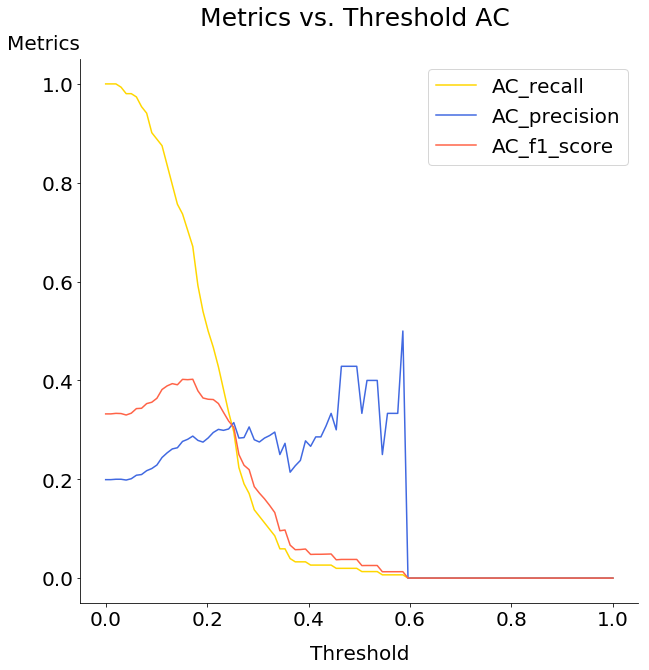

In [77]:
plt.figure(figsize= [10,10])
x=np.linspace(0,1,100)
y=recall_score_ac_n
y2=precision_score_ac_n
y3=f1_score_ac

ttl = ax.title
ttl.set_position([.5, 1.05])
plt.plot(x,y,label='AC_recall',color='gold')
plt.plot(x,y2,label='AC_precision',color='royalblue')
plt.plot(x,y3,label='AC_f1_score',color='tomato')
#plt.axvline(0.215, color='gold', linestyle='solid')
plt.title("Metrics vs. Threshold AC \n", size = 25)

plt.xlabel('Threshold', size = 20, labelpad = 15)
plt.ylabel('Metrics \n ', size = 20, rotation = 0, labelpad = 35)
plt.xticks(size=20)
plt.yticks(size=20)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.06,0.97)
sns.despine()
plt.legend(loc='best',prop={'size': 20});



In [78]:
y_ac_predlogn=log_ac_n.predict_proba(X1_test_n)[:,1] >0.17171717171717174
# y_ac_predlogn=log_ac_n.predict_proba(X1_test_n)[:,1] >x[np.argmax(roc_auc_ac_n)]

cm_ac_logn=confusion_matrix(y1_ac_test, y_ac_predlogn)
cm_ac_logn

array([[358, 253],
       [ 50, 102]])

In [79]:
print(classification_report(y1_ac_test, y_ac_predlogn))

             precision    recall  f1-score   support

        0.0       0.88      0.59      0.70       611
        1.0       0.29      0.67      0.40       152

avg / total       0.76      0.60      0.64       763



In [80]:
ind=np.argmax(precision_score_ac_n)
list(np.linspace(0,1,100))[ind]

0.5858585858585859

In [81]:
precision_score_ac_n[ind]

0.5

In [82]:
y_ac_predlogn=log_ac_n.predict_proba(X1_test_n)[:,1] >0.4646464646464647
# y_ac_predlogn=log_ac_n.predict_proba(X1_test_n)[:,1] >x[np.argmax(roc_auc_ac_n)]

cm_ac_logn=confusion_matrix(y1_ac_test, y_ac_predlogn)
cm_ac_logn

array([[607,   4],
       [149,   3]])

In [83]:
print(classification_report(y1_ac_test, y_ac_predlogn))

             precision    recall  f1-score   support

        0.0       0.80      0.99      0.89       611
        1.0       0.43      0.02      0.04       152

avg / total       0.73      0.80      0.72       763



In [84]:
recall_score_ipo_n=[]
precision_score_ipo_n=[]
f1_score_ipo=[]

for i in np.linspace(0,1,100):
    y_score=log_ipo_n.predict_proba(X1_test_n)[:,1]>i
#     sklearn.metrics.recall_score(y1_ac_test, y_pred)#, labels=None, pos_label=1, average=’binary’, sample_weight=None)
    
    precision_score_ipo_n.append(metrics.precision_score(y1_ipo_test, y_score))#, labels=None, pos_label=1, average=’binary’, sample_weight=None)
    recall_score_ipo_n.append(metrics.recall_score(y1_ipo_test, y_score))
    f1_score_ipo.append(metrics.f1_score(y1_ipo_test, y_score))


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: P

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


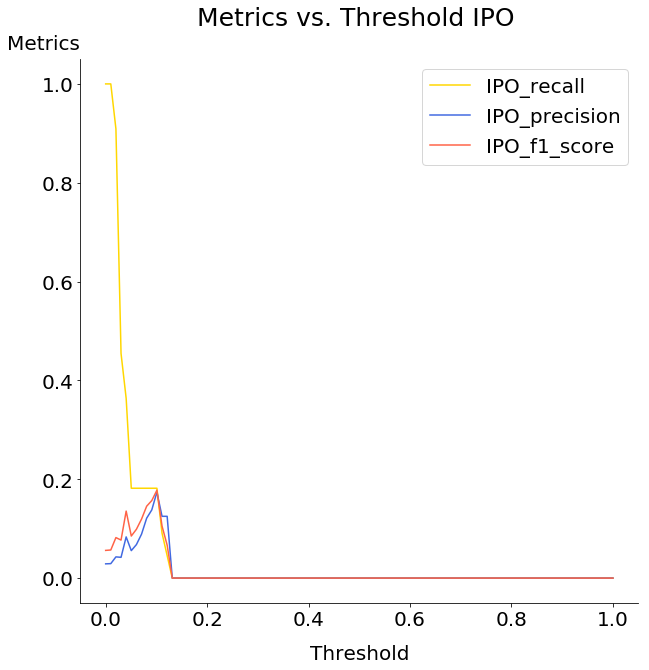

In [85]:
plt.figure(figsize= [10,10])
x=np.linspace(0,1,100)
y=recall_score_ipo_n
y2=precision_score_ipo_n
y3=f1_score_ipo
ttl = ax.title
ttl.set_position([.5, 1.05])
plt.plot(x,y,label='IPO_recall',color='gold')
plt.plot(x,y2,label='IPO_precision',color='royalblue')
plt.plot(x,y3,label='IPO_f1_score',color='tomato')
plt.title("Metrics vs. Threshold IPO \n", size = 25)
plt.xlabel('Threshold', size = 20, labelpad = 15)
plt.ylabel('Metrics \n', size = 20, rotation = 0, labelpad = 35)
plt.xticks(size=20)
plt.yticks(size=20)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.06,0.97)
sns.despine()
plt.legend(loc='best',prop={'size': 20});

In [86]:
ind=np.argmax(f1_score_ipo)
list(np.linspace(0,1,100))[ind]

0.10101010101010102

In [87]:
ind

10

In [88]:
f1_score_ipo[ind]

0.17777777777777776

In [89]:
y_ipo_predlogn=log_ipo_n.predict_proba(X1_test_n)[:,1] >0.06060606060606061
# y_ac_predlogn=log_ac_n.predict_proba(X1_test_n)[:,1] >x[np.argmax(roc_auc_ac_n)]

cm_ipo_logn=confusion_matrix(y1_ipo_test, y_ipo_predlogn)
cm_ipo_logn

array([[686,  55],
       [ 18,   4]])

In [90]:
print(classification_report(y1_ipo_test, y_ipo_predlogn))

             precision    recall  f1-score   support

        0.0       0.97      0.93      0.95       741
        1.0       0.07      0.18      0.10        22

avg / total       0.95      0.90      0.92       763



In [91]:
ind=np.argmax(precision_score_ipo_n)
list(np.linspace(0,1,100))[ind]

0.10101010101010102

In [92]:
precision_score_ipo_n[ind]

0.17391304347826086

In [93]:
y_ipo_predlogn=log_ipo_n.predict_proba(X1_test_n)[:,1] >0.3434343434343435
# y_ac_predlogn=log_ac_n.predict_proba(X1_test_n)[:,1] >x[np.argmax(roc_auc_ac_n)]

cm_ipo_logn=confusion_matrix(y1_ipo_test, y_ipo_predlogn)
cm_ipo_logn

array([[741,   0],
       [ 22,   0]])

In [94]:
print(classification_report(y1_ipo_test, y_ipo_predlogn))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.99       741
        1.0       0.00      0.00      0.00        22

avg / total       0.94      0.97      0.96       763



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [95]:
log_ac_n.best_estimator_.coef_

array([[-0.05607029, -0.06405014, -0.14948308, -0.02435112, -0.02174998,
         0.        , -0.08057955,  0.01008392,  0.        ,  0.        ,
         0.        ,  0.01192214, -0.05452995,  0.        , -0.00189516,
        -0.03579721, -0.1428007 , -0.08140897,  0.        ,  0.07749036,
        -0.00563359, -0.09427006,  0.06370253,  0.        , -0.03280137,
        -0.02751568,  0.        ,  0.        , -0.06704529, -0.06389118,
         0.        ,  0.05107303,  0.        , -0.06480791,  0.00106038,
         0.        ,  0.        ,  0.        ,  0.15127772,  0.11648408,
         0.09275978,  0.05172524,  0.03204681,  0.03670071,  0.08364458,
        -0.51266733, -0.58328216, -0.00738759,  0.04747185,  0.        ,
         0.        ]])

In [96]:
len(X1.columns)

51

In [97]:
names = X1.columns
coefs_ac = log_ac_n.best_estimator_.coef_[0]
coef_ac=pd.DataFrame({'names':names,'coefs_ac':coefs_ac })

In [98]:
coef_ac['abscoef']=abs(coef_ac['coefs_ac'])

coef_ac=coef_ac.sort_values(by='abscoef',ascending=False)
coef_ac

,names,coefs_ac,abscoef
46,ave_inf_y,-0.583282,0.583282
45,first_funding_dayinop,-0.512667,0.512667
38,category_code[T.web],0.151278,0.151278
2,category_code[T.biotech],-0.149483,0.149483
16,category_code[T.manufacturing],-0.142801,0.142801
39,CA,0.116484,0.116484
21,category_code[T.nanotech],-0.094270,0.094270
40,NY,0.092760,0.092760
44,founded_month,0.083645,0.083645
17,category_code[T.medical],-0.081409,0.081409


In [99]:
coef2_ac=coef_ac.iloc[:18]
coef2_ac

,names,coefs_ac,abscoef
46,ave_inf_y,-0.583282,0.583282
45,first_funding_dayinop,-0.512667,0.512667
38,category_code[T.web],0.151278,0.151278
2,category_code[T.biotech],-0.149483,0.149483
16,category_code[T.manufacturing],-0.142801,0.142801
39,CA,0.116484,0.116484
21,category_code[T.nanotech],-0.094270,0.094270
40,NY,0.092760,0.092760
44,founded_month,0.083645,0.083645
17,category_code[T.medical],-0.081409,0.081409


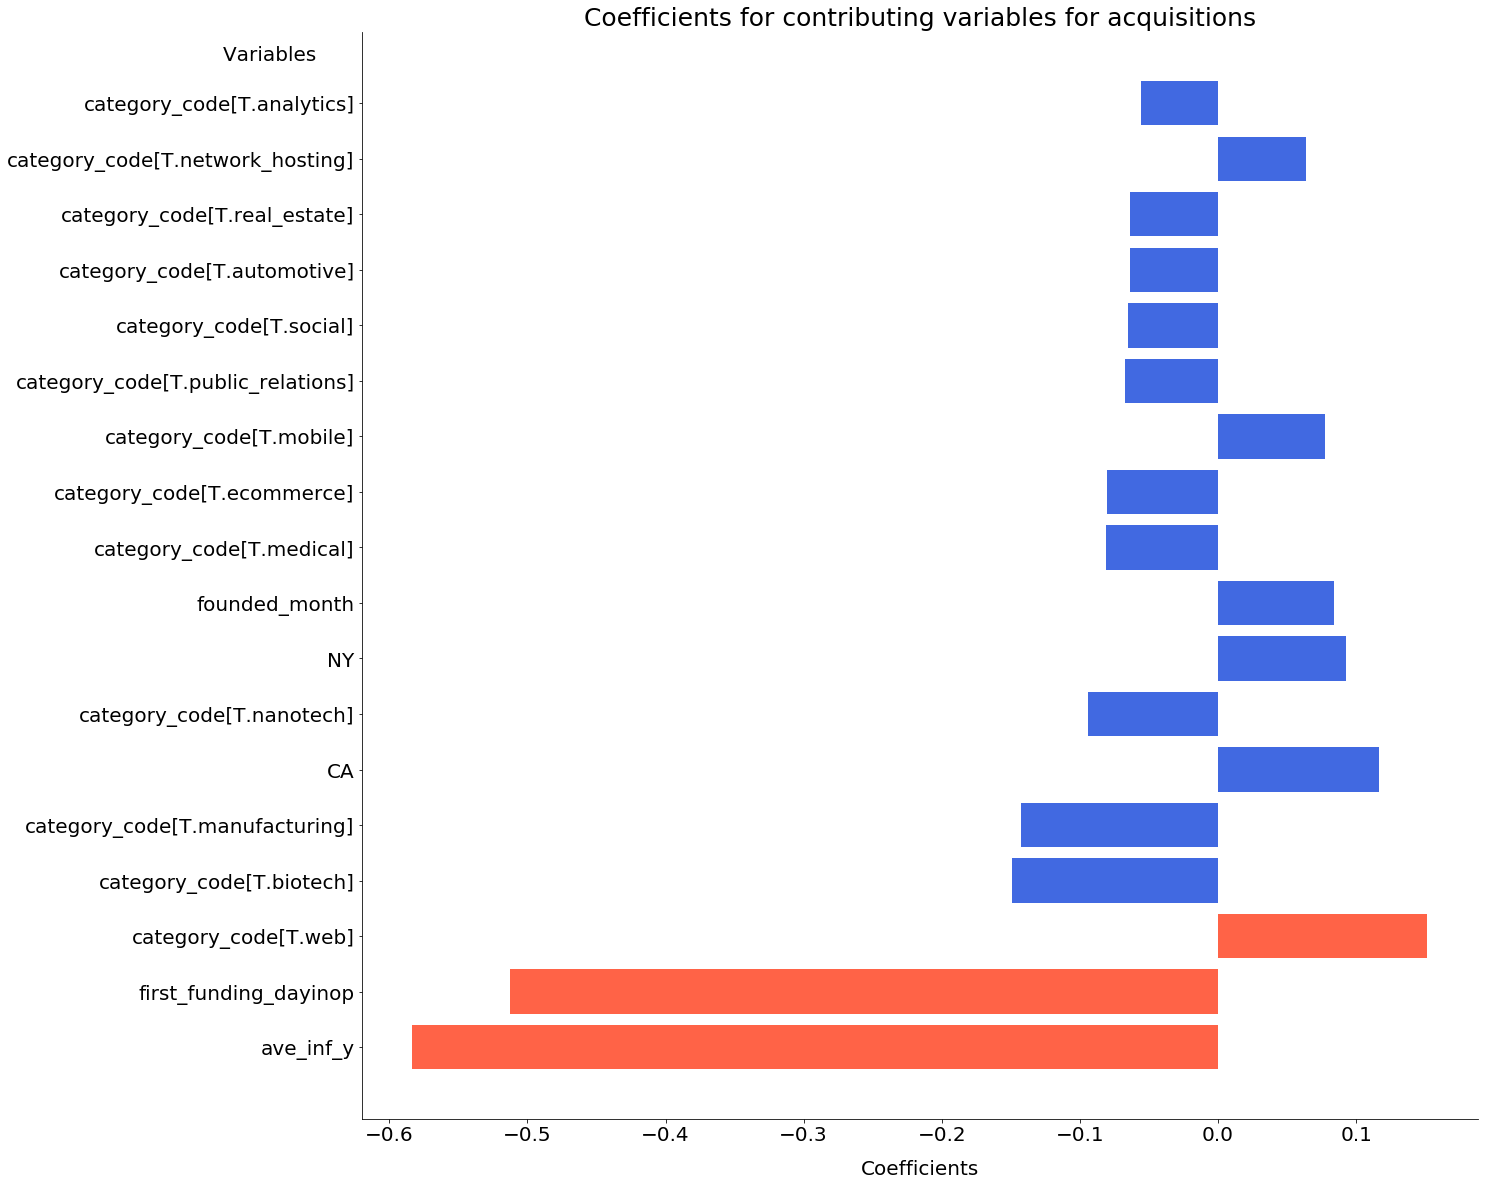

In [100]:
plt.figure(figsize= [20,20])
crange = np.arange(len(coef2_ac))
# # print(crange.shape, coefs.shape)
plt.barh(crange, coef2_ac['coefs_ac'],color='royalblue')
plt.barh(crange[:3], coef2_ac['coefs_ac'][:3],color='tomato')
plt.yticks(crange, coef2_ac['names'])
ax = plt.gca()
# plt.yticks(np.arange(10), [x for x,y in ticks_y])
plt.title("Coefficients for contributing variables for acquisitions", size = 25)
plt.xlabel('Coefficients', size = 20, labelpad = 15)
plt.ylabel('Variables        ', size = 20, rotation = 0, labelpad = 35)
plt.xticks(size=20)
plt.yticks(size=20)
ax.yaxis.set_label_coords(-0.06,0.97)
sns.despine()

In [101]:
names = X1.columns
coefs_ipo = log_ipo_n.best_estimator_.coef_[0]
coef_ipo=pd.DataFrame({'names':names,'coefs_ipo':coefs_ipo })

In [102]:
coef_ipo['abscoef']=abs(coef_ipo['coefs_ipo'])

coef_ipo=coef_ipo.sort_values(by='abscoef',ascending=False)
coef_ipo

,names,coefs_ipo,abscoef
2,category_code[T.biotech],0.314785,0.314785
46,ave_inf_y,-0.302534,0.302534
3,category_code[T.cleantech],0.124855,0.124855
38,category_code[T.web],-0.102586,0.102586
48,ag_raised_amount_usd_adj,-0.097644,0.097644
29,category_code[T.real_estate],0.052558,0.052558
37,category_code[T.travel],0.051771,0.051771
1,category_code[T.automotive],0.045634,0.045634
40,NY,-0.040529,0.040529
22,category_code[T.network_hosting],0.023348,0.023348


In [103]:
coef2_ipo=coef_ipo.iloc[:18]
coef2_ipo

,names,coefs_ipo,abscoef
2,category_code[T.biotech],0.314785,0.314785
46,ave_inf_y,-0.302534,0.302534
3,category_code[T.cleantech],0.124855,0.124855
38,category_code[T.web],-0.102586,0.102586
48,ag_raised_amount_usd_adj,-0.097644,0.097644
29,category_code[T.real_estate],0.052558,0.052558
37,category_code[T.travel],0.051771,0.051771
1,category_code[T.automotive],0.045634,0.045634
40,NY,-0.040529,0.040529
22,category_code[T.network_hosting],0.023348,0.023348


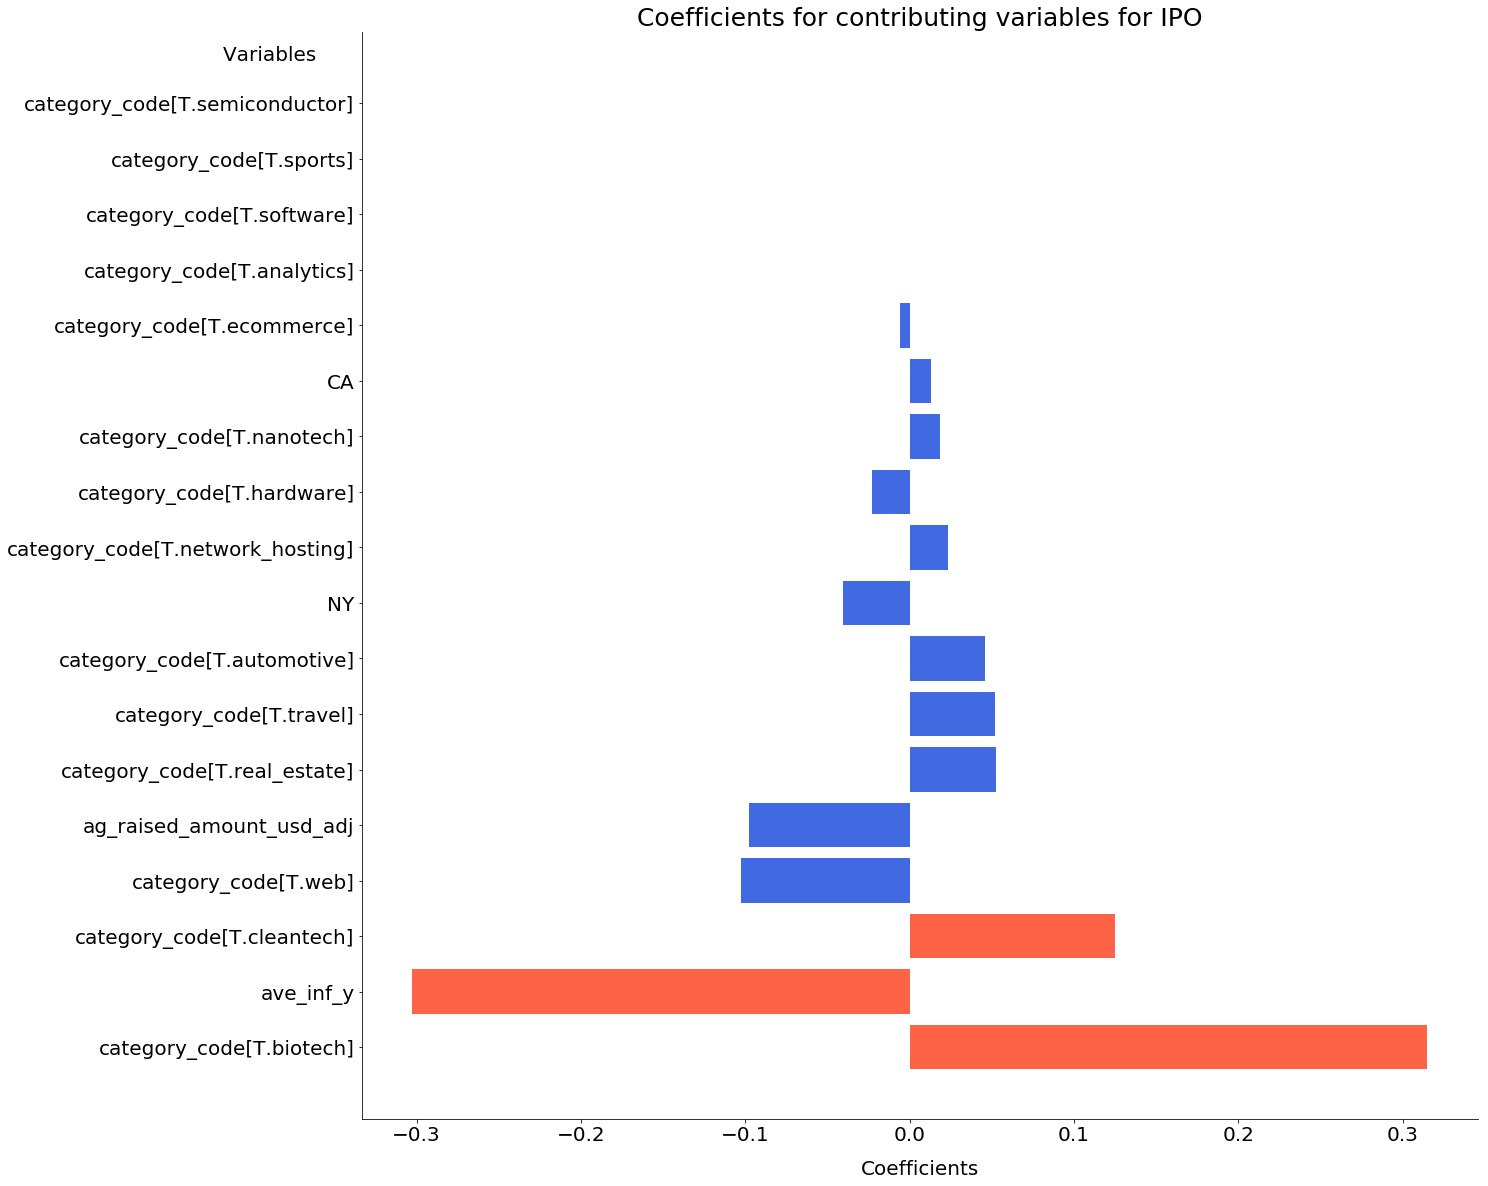

In [104]:
plt.figure(figsize= [20,20])
crange = np.arange(len(coef2_ipo))
# # print(crange.shape, coefs.shape)
plt.barh(crange, coef2_ipo['coefs_ipo'],color='royalblue')
plt.barh(crange[:3], coef2_ipo['coefs_ipo'][:3],color='tomato')
plt.yticks(crange, coef2_ipo['names'])
ax = plt.gca()
# plt.yticks(np.arange(10), [x for x,y in ticks_y])
plt.title("Coefficients for contributing variables for IPO", size = 25)
plt.xlabel('Coefficients', size = 20, labelpad = 15)
plt.ylabel('Variables        ', size = 20, rotation = 0, labelpad = 35)
plt.xticks(size=20)
plt.yticks(size=20)
ax.yaxis.set_label_coords(-0.06,0.97)
sns.despine()

In [105]:
pickle.dump(Model_data_ac, open("Model_data_ac_wo_sa_mod.pickle", "wb"))

NameError: name 'pickle' is not defined

In [ ]:
pickle.dump(Model_data_ipo, open("Model_data_ipo_wo_sa_mod.pickle", "wb"))

In [ ]:
Model_data_ac.to_csv('Model_data_ac_wo_sa.csv')

In [ ]:
Model_data_ipo.to_csv('Model_data_ipo_wo_sa.csv')

In [ ]:
log_ac_n.best_params_


In [ ]:
coef=pd.merge(coef_ipo,coef_ac,how='left', on='names')

In [ ]:
coef=coef.sort_values(by='abscoef_y',ascending=False)

In [ ]:
coef

In [ ]:
plt.figure(figsize= [20,20])
crange = np.arange(len(coef))
# # print(crange.shape, coefs.shape)
plt.barh(crange, coef['coefs_ac'],color='tomato')
plt.barh(crange, coef['coefs_ipo'],color='royalblue')
plt.yticks(crange, coef['names'])
ax = plt.gca()
# plt.yticks(np.arange(10), [x for x,y in ticks_y])
plt.title("Comparison of coefficients for contributing variables for IPO and acquisitions", size = 25)
plt.xlabel('Coefficients', size = 20, labelpad = 15)
plt.ylabel('Variables        ', size = 20, rotation = 0, labelpad = 35)
plt.xticks(size=20)
plt.yticks(size=20)
ax.yaxis.set_label_coords(-0.06,0.97)
sns.despine()